# Global EASE-Grid 8-day Blended SSM/I and MODIS Snow Cover, Version 1

- Data: https://nsidc.org/data/NSIDC-0321/versions/1 (downloaded 14/10/2020)

## Abstract
This data set comprises global, 8-day Snow-Covered Area (SCA) and Snow Water Equivalent (SWE) data from 2000 through 2008. Global SWE data are derived from the Special Sensor Microwave Imager (SSM/I) and are enhanced with MODIS/Terra Snow Cover 8-Day Level 3 Global 0.05 degree Climate Modeling Grid (CMG) data. Global data are gridded to the Northern and Southern 25 km Equal-Area Scalable Earth Grids (EASE-Grids). These data are suitable for continental-scale time-series studies of snow cover and snow water equivalent. The data are in netCDF data files and PNG browse image files available via FTP.

## Data access on CICLAD
Path on CICLAD: `/data/mlalande/NSIDC/nsidc0321_blended_ssmi_modis/`


## Python environment
conda env: new `phd_v3` (in `envs/phd`)

# Import modules

In [3]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
# sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
sys.path.insert(1, '/home/lalandmi/Dropbox/Thèse/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


In [4]:
xr.__version__

'0.16.0'

# Define paths

In [6]:
# path = '/data/mlalande/NSIDC/nsidc0321_blended_ssmi_modis/'
path = '/home/lalandmi/data/nsidc0321_blended_ssmi_modis/'

# Get data

In [63]:
ds = xr.open_mfdataset(path+'/north/NL.*.nsidc0321v01.nc', combine='by_coords')

In [62]:
# ds

In [8]:
scf_with_mask = ds.SCA
swe_with_mask = ds.SWE

In [61]:
# scf_with_mask
# swe_with_mask

### SCF
 0          : no snow  
 1 to 100   : percent MODIS snow-covered area  
 -175       : no SCA, due to to cloud/fill/night  
 -200       : fixed value for corners  
 -250       : ocean  
 -300       : permanent ice sheets and large glaciers

### SWE
 \> 0       : SWE from deep microwave algorithm for 8-day period  
 0          : no snow  
 -100 to -1 : -1 * SWE from shallow microwave algorithm  
 -150       : missing microwave brightness temperatures  
 -200       : fixed value for corners  
 -250       : ocean  
 -300       : permanent ice sheets and large glaciers  
 -350       : no microwave SWE, but visible SCA > 25%

In [14]:
scf = scf_with_mask.where( (scf_with_mask >= 0) & (scf_with_mask <= 100) )
no_SCA_due_to_cloud_fill_night = scf_with_mask.where(scf_with_mask == -175)
grid_corners = scf_with_mask.where(scf_with_mask == -200)
ocean = scf_with_mask.where(scf_with_mask == -250)
permanent_ice_sheets_and_large_glaciers = scf_with_mask.where(scf_with_mask == -300)

swe = swe_with_mask.where(swe_with_mask >= 0)
swe_from_mw_algo = -1 * swe_with_mask.where( (swe_with_mask >= -100) & (swe_with_mask <= -1) )
no_microwave_data = swe_with_mask.where(swe_with_mask == -150)
grid_corners = swe_with_mask.where(swe_with_mask == -200)
ocean = swe_with_mask.where(swe_with_mask == -250)
permanent_ice_sheets_and_large_glaciers = swe_with_mask.where(swe_with_mask == -300)
no_microwave_SWE_but_visible_SCA_gt_25_pcent = swe_with_mask.where(swe_with_mask == -350)

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/matplotlib/contour.py:1483: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/matplotlib/contour.py:1484: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


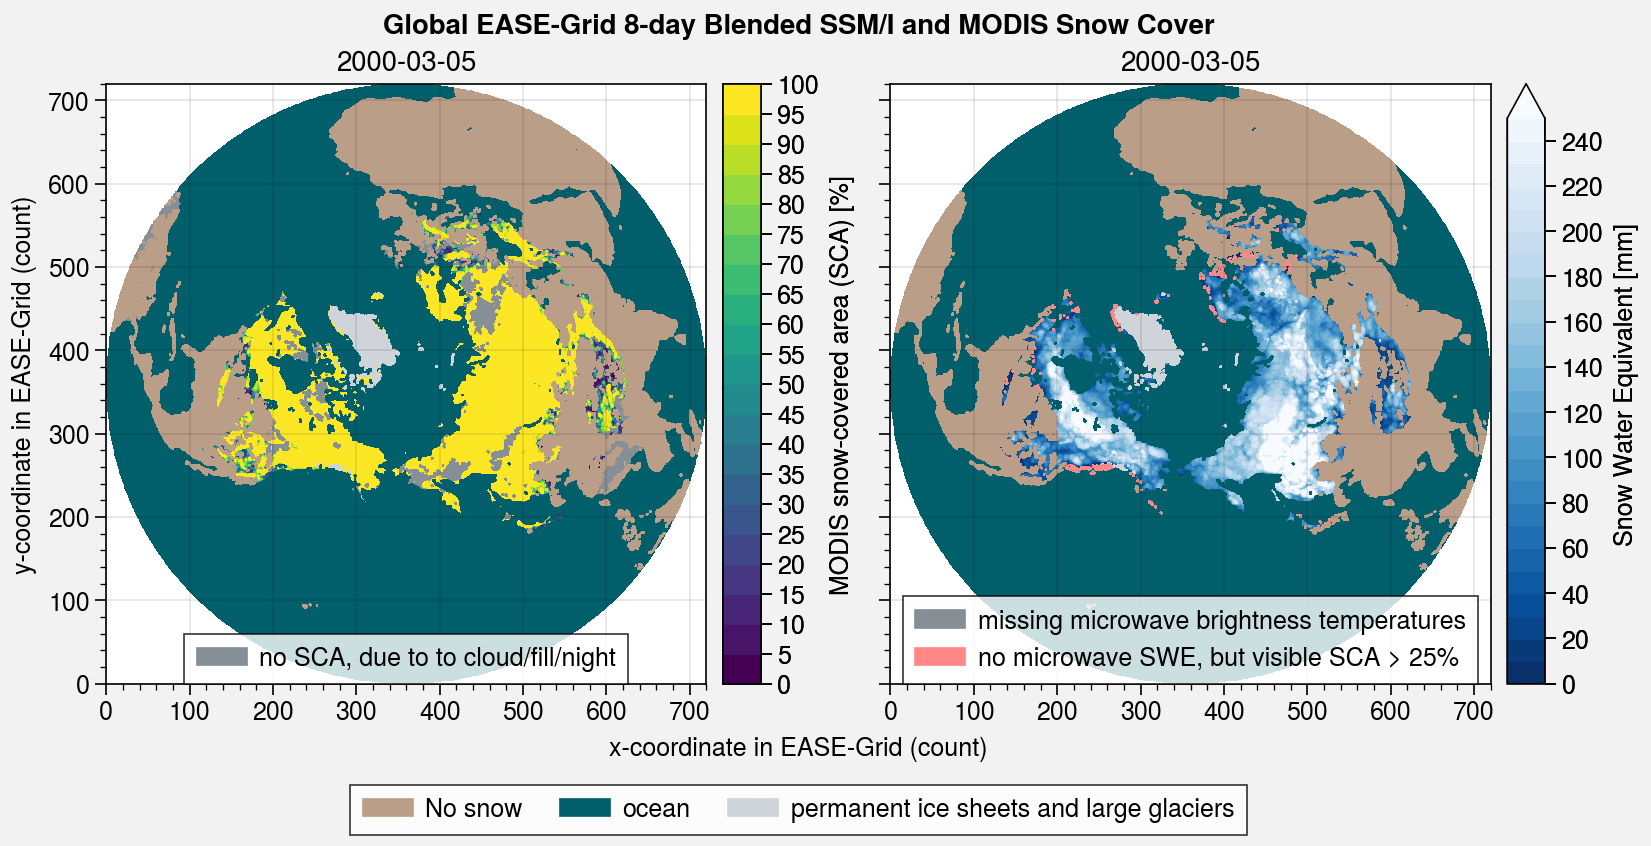

In [66]:
import matplotlib.patches as mpatches

fig, axs = plot.subplots(proj=None, axwidth=3, ncols=2)

cmap_scf='viridis'
levels_scf=plot.arange(0,100,5)
extend_scf='neither'

cmap_swe='Blues_r'
levels_swe=plot.arange(0,250,10)
extend_swe='max'

label_no_SCA_due_to_cloud_fill_night = 'no SCA, due to to cloud/fill/night'
color_no_SCA_due_to_cloud_fill_night = 'gray6'

label_grid_corners = 'fixed value for corners'
color_grid_corners = 'bisque'

label_ocean = 'ocean'; color_ocean = 'petrol'

label_permanent_ice_sheets_and_large_glaciers = 'permanent ice sheets and large glaciers'
color_permanent_ice_sheets_and_large_glaciers = 'gray4'

label_no_microwave_data = 'missing microwave brightness temperatures'
color_no_microwave_data = 'gray6'

label_no_microwave_SWE_but_visible_SCA_gt_25_pcent = 'no microwave SWE, but visible SCA > 25%'
color_no_microwave_SWE_but_visible_SCA_gt_25_pcent = 'red4'

label_no_snow = 'No snow'; color_no_snow = 'mushroom'

#######
# SCF #
#######
m = axs[0].contourf(scf.isel(time=0), cmap=cmap_scf, levels=levels_scf, extend=extend_scf)
axs[0].colorbar(m, label=scf.long_name + ' [' + scf.units + ']')
axs[0].format(title=str(scf.isel(time=0).time.values)[:10])

# no_snow
axs[0].contourf(no_SCA_due_to_cloud_fill_night.isel(time=0), color=color_no_SCA_due_to_cloud_fill_night)
no_SCA_due_to_cloud_fill_night_patch = mpatches.Patch(color=color_no_SCA_due_to_cloud_fill_night, label=label_no_SCA_due_to_cloud_fill_night)

# ocean
axs[0].contourf(ocean.isel(time=0), color=color_ocean)
ocean_patch = mpatches.Patch(color=color_ocean, label=label_ocean)

# permanent_ice_sheets_and_large_glaciers
axs[0].contourf(permanent_ice_sheets_and_large_glaciers.isel(time=0), color=color_permanent_ice_sheets_and_large_glaciers)
permanent_ice_sheets_and_large_glaciers_patch = mpatches.Patch(color=color_permanent_ice_sheets_and_large_glaciers, label=label_permanent_ice_sheets_and_large_glaciers)

# no snow
axs[0].contourf(scf.isel(time=0).where(scf.isel(time=0) == 0), color=color_no_snow)
no_snow_patch = mpatches.Patch(color=color_no_snow, label=label_no_snow)

axs[0].legend(
    [no_SCA_due_to_cloud_fill_night_patch], 
    loc='lc', ncols=1)

#######
# SWE #
#######
m = axs[1].contourf(swe.isel(time=0), cmap=cmap_swe, levels=levels_swe, extend=extend_swe)
axs[1].colorbar(m, label=swe.long_name + ' [' + swe.units + ']')
axs[1].format(title=str(swe.isel(time=0).time.values)[:10])

axs[1].contourf(swe_from_mw_algo.isel(time=0), cmap=cmap_swe, levels=levels_swe, extend=extend_swe)

# ocean
axs[1].contourf(ocean.isel(time=0), color=color_ocean)
ocean_patch = mpatches.Patch(color=color_ocean, label=label_ocean)

# permanent_ice_sheets_and_large_glaciers
axs[1].contourf(permanent_ice_sheets_and_large_glaciers.isel(time=0), color=color_permanent_ice_sheets_and_large_glaciers)
permanent_ice_sheets_and_large_glaciers_patch = mpatches.Patch(color=color_permanent_ice_sheets_and_large_glaciers, label=label_permanent_ice_sheets_and_large_glaciers)

# no_microwave_data
axs[1].contourf(no_microwave_data.isel(time=0), color=color_no_microwave_data)
no_microwave_data_patch = mpatches.Patch(color=color_no_microwave_data, label=label_no_microwave_data)

# no_microwave_SWE_but_visible_SCA_gt_25_pcent
axs[1].contourf(no_microwave_SWE_but_visible_SCA_gt_25_pcent.isel(time=0), color=color_no_microwave_SWE_but_visible_SCA_gt_25_pcent)
no_microwave_SWE_but_visible_SCA_gt_25_pcent_patch = mpatches.Patch(color=color_no_microwave_SWE_but_visible_SCA_gt_25_pcent, label=label_no_microwave_SWE_but_visible_SCA_gt_25_pcent)

# no snow
axs[1].contourf(swe.isel(time=0).where(swe.isel(time=0) == 0), color=color_no_snow)
no_snow_patch = mpatches.Patch(color=color_no_snow, label=label_no_snow)

axs[1].legend(
    [no_microwave_data_patch, no_microwave_SWE_but_visible_SCA_gt_25_pcent_patch], 
    loc='lc', ncols=1)

fig.legend(
    [no_snow_patch, ocean_patch, permanent_ice_sheets_and_large_glaciers_patch], 
    loc='b', ncols=3)

axs.format(
    suptitle=ds.title
)